# _Part 1: Set-up_

In [1]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [4]:
path.ls()

[PosixPath('/home/jupyter/springboard-capstone-2/data/train_atel.csv'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/CheXpert-v1.0-small'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/models'),
 PosixPath('/home/jupyter/springboard-capstone-2/data/.ipynb_checkpoints')]

# _Part 2: Data Preparation_

In [5]:
train_df = pd.read_csv(path/'CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv(path/'CheXpert-v1.0-small/valid.csv')

In [6]:
# competition tasks (pathologies) divided into best performing uncertatinty approachs (limited to U-One/U-Zero)
u_one_features = ['Atelectasis', 'Edema', 'Pleural Effusion']
u_zero_features = ['Cardiomegaly', 'Consolidation']

In [7]:
# create function to return features for each observation
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [8]:
# add column denoting if observation is from validation set
train_df['valid'] = False
valid_df['valid'] = True

In [9]:
# create patient and study columns
train_df['patient'] = train_df.Path.str.split('/',3,True)[2]
valid_df['patient'] = valid_df.Path.str.split('/',3,True)[2]

train_df['study'] = train_df.Path.str.split('/',4,True)[3]
valid_df['study'] = valid_df.Path.str.split('/',4,True)[3]

In [10]:
full_df = pd.concat([train_df, valid_df])

In [11]:
full_df['feature_string'] = full_df.apply(feature_string, axis=1).fillna('')

## _Create Function to Seed Data, Get Sample DF, and for AUC_

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [21]:
def get_sample_df(sample_perc = 0.05):
    
    train_only_df = full_df[~full_df.valid]
    valid_only_df = full_df[full_df.valid]
    unique_patients = train_only_df.patient.unique()
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]

    sample_df = train_only_df[train_df.patient.isin(sample_patients)]
    return pd.concat([sample_df,valid_only_df])

In [43]:
from sklearn.metrics import roc_auc_score

def avg_auc_metric(input, targs):
    input=input.detach().cpu()
    targs=targs.view(-1).long()
    auc_scores = [roc_auc_score(targs[:,i],input[:,i]) for i in range(targs.shape[1])]
    auc_scores = torch.tensor(auc_scores)
    return auc_scores.mean()

# _Fast.AI Data Set-Up_

In [17]:
seed_everything(1)

In [26]:
sample_df = get_sample_df(0.10)
sample_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study,feature_string
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00004,study1,
6,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Lateral,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,patient00004,study1,
85,CheXpert-v1.0-small/train/patient00025/study2/...,Male,64,Frontal,PA,NaN,-1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,False,patient00025,study2,Atelectasis;Pleural Effusion
86,CheXpert-v1.0-small/train/patient00025/study2/...,Male,64,Lateral,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,False,patient00025,study2,Atelectasis;Pleural Effusion
87,CheXpert-v1.0-small/train/patient00025/study1/...,Male,64,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,False,patient00025,study1,


In [30]:
torch.cuda.empty_cache()

In [31]:
# default transformations
tfms = get_transforms()

In [32]:
src = (ImageList.from_df(df=sample_df, path=path, folder='.', suffix='').split_from_df('valid')
      .label_from_df('feature_string', label_delim=';'))

In [33]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 2432MB of GPU RAM free


In [35]:
data = (src.transform(tfms, size = 64, padding_mode='zeros')
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [37]:
print(data.c)
print(data.classes)

5
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


### Create Learner

In [48]:
# create metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [49]:
learn = cnn_learner(data, base_arch=models.resnet101, metrics=[acc_02, f_score], pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.71E-02
Min loss divided by 10: 1.07E-02


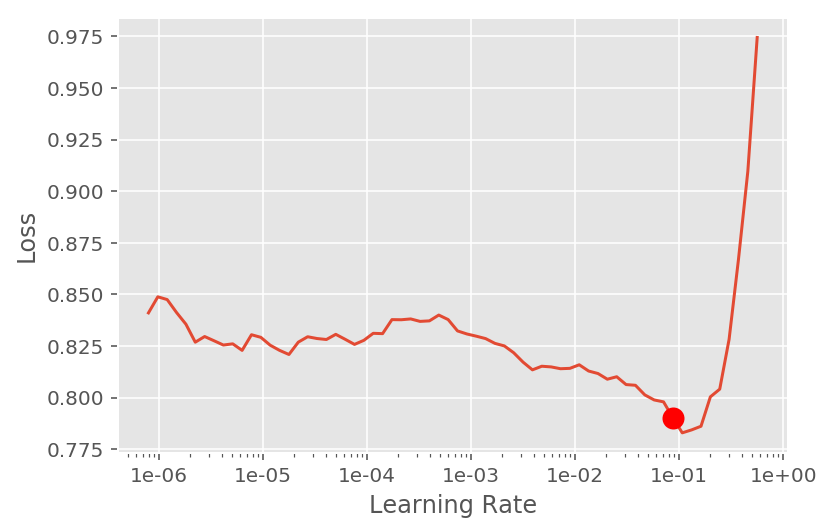

In [50]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [51]:
lr = 1e-2
lr

0.01

# _Rd. 1 Training_

In [52]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.504386,0.549237,0.534188,0.331534,02:33
1,0.487638,6.055635,0.650427,0.259272,02:34
2,0.462935,0.548497,0.612821,0.338785,02:33
3,0.456923,0.761203,0.664957,0.342937,02:36


In [53]:
learn.save('replicate-chexpert-rd1')

# _Rd. 2 Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.24E-06
Min loss divided by 10: 5.13E-07


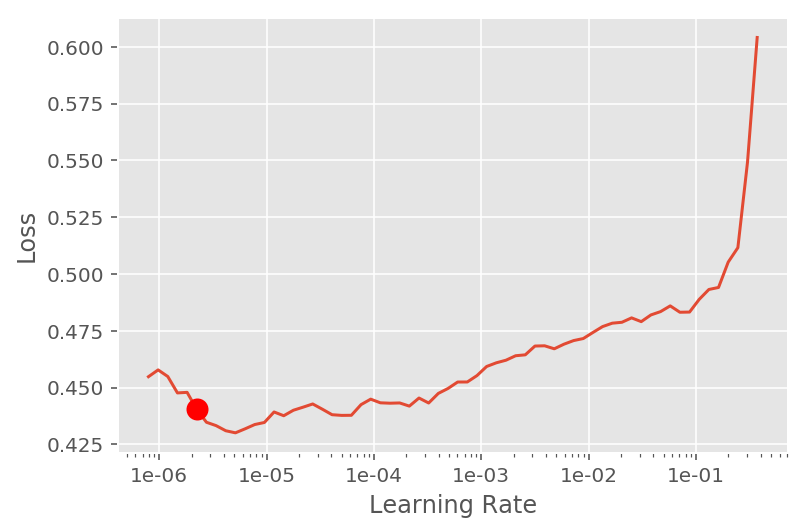

In [54]:
# unfreeze all layers
learn.unfreeze()

learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [55]:
lr = learn.recorder.min_grad_lr
lr

2.2387211385683393e-06

In [56]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) # fit model with differential learning rates

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.453493,0.560499,0.661539,0.353698,03:20
1,0.444386,0.552334,0.646154,0.347216,03:19
2,0.440132,0.530012,0.662393,0.336459,03:21
3,0.447410,0.490028,0.669231,0.353593,03:18
4,0.438917,0.488568,0.675214,0.346300,03:20


In [59]:
learn.save('replicate-chexpert-rd2')

# _Resize Data to 128_

In [57]:
data = (src.transform(tfms, size = 128, padding_mode='zeros')
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [60]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [61]:
learn.freeze()

# _Rd. 3 Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.82E-06
Min loss divided by 10: 7.94E-08


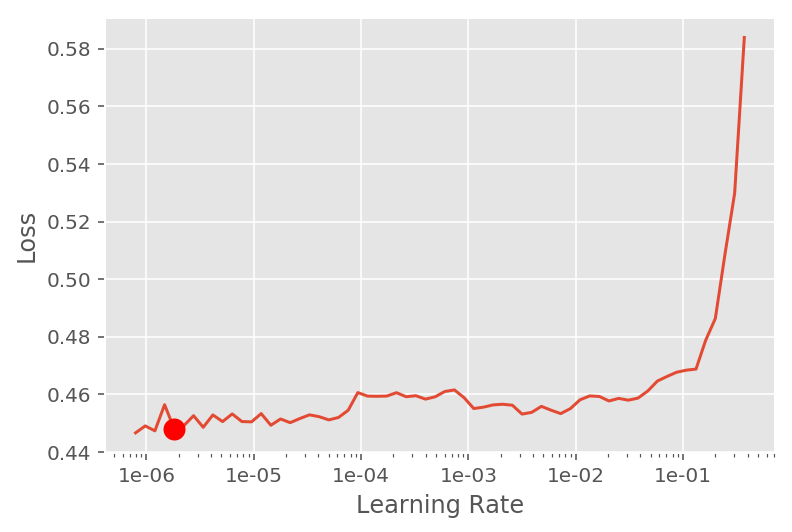

In [62]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [63]:
lr = learn.recorder.min_grad_lr
lr

1.819700858609984e-06

In [64]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.470318,0.555133,0.636752,0.322391,03:01
1,0.471091,0.517297,0.634188,0.329076,03:01
2,0.464984,0.533082,0.670086,0.313270,03:00


In [65]:
learn.save('replicate-chexpert-rd3')